# Загрузка библиотек

In [1]:
pip install yfinance

  Preparing metadata (setup.py) ... - done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=8b23cba39b24b8cdb9465e0ddd48d1ab62404ccc5ce8567152fb53ad5edf70ce
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-uvxlqq1l
  Running command git clone --filter=blob:none --quiet https://github.com/prog815/progOrder /tmp/pip-req-build-uvxlqq1l
  Resolved https://github.com/prog815/progOrder to commit da7c7d38cd9609ee97bcf13032c088475c8a259b
  Preparing metadata (setup.py) ... - done
  Created wheel for progOrder: filename=progOrder-0.0.5-py3-none-any.whl size=2628 sha256=3d1cb4e82eda50cd3524ddead977f52f3389fc106c690c3f65f227c56371b66f
  Stored in directory: /tmp/pip-ephem-wheel-cache-yqent79_/wheels/90/27/db/48a874d26924c492944ffd71d357e9002e1e70cc4e04dede4f
Successfully built progOrder
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd 
import yfinance as yf
import progOrder

# Загрузка котировок

In [4]:
data = yf.download('SBER.ME',period='10y')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-02,94.470001,95.690002,93.059998,93.120003,51.650772,106143030
2012-05-03,93.300003,93.639999,92.120003,92.889999,51.523205,10646420
2012-05-04,92.120003,92.639999,90.320000,90.900002,50.419407,154978600
2012-05-07,89.000000,89.870003,86.000000,88.360001,49.010555,8603371
2012-05-08,89.019997,90.400002,87.629997,89.089996,49.415459,10447514
...,...,...,...,...,...,...
2022-04-22,118.650002,122.320000,115.550003,116.970001,116.970001,57466590
2022-04-25,116.970001,116.970001,116.970001,116.970001,116.970001,0
2022-04-26,112.580002,124.919998,111.900002,122.360001,122.360001,83540530


# Подготовка данных для модели

In [5]:
?progOrder.getBuySellForData

In [6]:
window = 100 
test_part = 0.2

# подготовка входов
df = pd.DataFrame(index=data.index)
df['dClose'] = data['Close'].pct_change()

# оконный сдвиг
for name in df.columns:
    for n in range(1,window):
        df[name + "_" + str(n)] = df[name].shift(n)

# добавляем дату
df['dow'] = df.index.day_of_week
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

df['dom'] = data.reset_index()['Date'].dt.day.values
df['dom_sin'] = np.sin(2 * np.pi * df['dom'] / 31)
df['dom_cos'] = np.cos(2 * np.pi * df['dom'] / 31)

df['month'] = data.reset_index()['Date'].dt.month.values
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['week'] = data.reset_index()['Date'].dt.isocalendar().week.values - 1
df['week_sin'] = np.sin(2 * np.pi * df['month'] / 53)
df['week_cos'] = np.cos(2 * np.pi * df['month'] / 53)

# размножаем на два типа ордеров
data_buy = df.copy()
data_sell = df.copy()

# добавляем таргет
ohlc = data.values[:,:4]
buy,sell = progOrder.getBuySellForData(ohlc,SP=0.05)
data_buy['Target'] = buy.astype(int)
data_sell['Target'] = sell.astype(int)

# выделяем размер тестовой

test_len = int((data.shape[0]-window-1)*test_part)

# выделяем обучающую

data_buy_train = data_buy.iloc[window+1:-test_len-1,:]
data_sell_train = data_sell.iloc[window+1:-test_len-1,:]

# выделяем тестовоую

data_buy_test = data_buy.iloc[-test_len-1:-1,:]
data_sell_test = data_sell.iloc[-test_len-1:-1,:]

# выделяем расчетную

data_buy_calc = data_buy.iloc[[-1],:]
data_sell_calc = data_sell.iloc[[-1],:]

data_buy_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

,dClose,dClose_1,dClose_2,dClose_3,dClose_4,dClose_5,dClose_6,dClose_7,dClose_8,dClose_9,...,dom,dom_sin,dom_cos,month,month_sin,month_cos,week,week_sin,week_cos,Target
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-14,-0.018686,-0.021369,-0.023569,0.002609,-0.000971,0.004878,0.005473,-0.018048,0.007406,0.015560,...,14,0.299363,-0.954139,5,0.500000,-0.866025,19,0.558647,0.829406,0
2020-05-15,0.000218,-0.018686,-0.021369,-0.023569,0.002609,-0.000971,0.004878,0.005473,-0.018048,0.007406,...,15,0.101168,-0.994869,5,0.500000,-0.866025,19,0.558647,0.829406,0
2020-05-18,0.027631,0.000218,-0.018686,-0.021369,-0.023569,0.002609,-0.000971,0.004878,0.005473,-0.018048,...,18,-0.485302,-0.874347,5,0.500000,-0.866025,20,0.558647,0.829406,0
2020-05-19,0.000371,0.027631,0.000218,-0.018686,-0.021369,-0.023569,0.002609,-0.000971,0.004878,0.005473,...,19,-0.651372,-0.758758,5,0.500000,-0.866025,20,0.558647,0.829406,0
2020-05-20,0.026349,0.000371,0.027631,0.000218,-0.018686,-0.021369,-0.023569,0.002609,-0.000971,0.004878,...,20,-0.790776,-0.612106,5,0.500000,-0.866025,20,0.558647,0.829406,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-21,0.000000,0.009975,-0.028664,-0.053713,0.014181,-0.047601,0.000886,-0.023866,-0.034999,-0.025627,...,21,-0.897805,-0.440394,4,0.866025,-0.500000,15,0.456629,0.889657,0
2022-04-22,-0.037284,0.000000,0.009975,-0.028664,-0.053713,0.014181,-0.047601,0.000886,-0.023866,-0.034999,...,22,-0.968077,-0.250653,4,0.866025,-0.500000,15,0.456629,0.889657,0
2022-04-25,0.000000,-0.037284,0.000000,0.009975,-0.028664,-0.053713,0.014181,-0.047601,0.000886,-0.023866,...,25,-0.937752,0.347305,4,0.866025,-0.500000,16,0.456629,0.889657,0


In [7]:
# контроль средних
pd.DataFrame([data_buy_train.describe().loc['mean',:],data_buy_test.describe().loc['mean',:]],index=['train','test'])

,dClose,dClose_1,dClose_2,dClose_3,dClose_4,dClose_5,dClose_6,dClose_7,dClose_8,dClose_9,...,dom,dom_sin,dom_cos,month,month_sin,month_cos,week,week_sin,week_cos,Target
train,0.000562,0.000573,0.000588,0.000586,0.000581,0.000574,0.000568,0.000595,0.000588,0.000578,...,16.020408,-0.017043,-0.031495,6.566719,-0.000294,0.023421,25.913658,0.643804,0.652500,0.026688
test,-0.000128,-0.000322,-0.000468,-0.000462,-0.000386,-0.000376,-0.000386,-0.000363,-0.000235,-0.000233,...,15.937238,-0.021287,-0.032341,6.757322,-0.062611,0.007247,26.635983,0.660920,0.638589,0.033473


In [8]:
# контроль стандартного отклонения
pd.DataFrame([data_buy_train.describe().loc['std',:],data_buy_test.describe().loc['std',:]],index=['train','test'])

,dClose,dClose_1,dClose_2,dClose_3,dClose_4,dClose_5,dClose_6,dClose_7,dClose_8,dClose_9,...,dom,dom_sin,dom_cos,month,month_sin,month_cos,week,week_sin,week_cos,Target
train,0.020051,0.020044,0.020037,0.020037,0.020038,0.020039,0.020040,0.020050,0.020050,0.020048,...,8.700430,0.713833,0.699773,3.487993,0.713373,0.700767,15.173460,0.285382,0.280001,0.161211
test,0.031855,0.031700,0.031647,0.031647,0.031602,0.031603,0.031601,0.031584,0.031491,0.031493,...,8.720697,0.712588,0.702006,3.441591,0.697594,0.715177,15.138124,0.281585,0.276450,0.180056


# Создание модели

In [9]:
pip install -U lightautoml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.2/296.2 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 KB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.0/425.0 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 31.4 MB/s e

In [10]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [11]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

In [12]:
task = Task('binary')
roles = { 'target': 'Target'}
automl = TabularAutoML(task,
                      reader_params={'cv' : 7})

# Обучение модели

In [13]:
oof_pred = automl.fit_predict(data_buy_train,roles=roles,verbose=1)

[08:15:28] Stdout logging level is INFO.
[08:15:28] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[08:15:28] Task: binary

[08:15:28] Start automl preset with listed constraints:
[08:15:28] - time: 3600.00 seconds
[08:15:28] - CPU: 4 cores
[08:15:28] - memory: 16 GB

[08:15:28] Train data shape: (1911, 113)

[08:15:31] Layer 1 train process start. Time left 3596.61 secs
[08:15:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:15:34] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.5301813198397638
[08:15:34] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[08:15:34] Time left 3593.33 secs

[08:15:35] Selector_LightGBM fitting and predicting completed
[08:15:36] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[08:15:43] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.5911026776301919
[08:15:43] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[08:15:43] Start hyperparameters optimization for L

In [14]:
oof_pred.data.max()

0.10797447

In [15]:
import seaborn as sns

<AxesSubplot:>

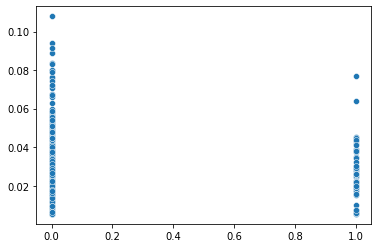

In [16]:
sns.scatterplot(x=data_buy_train['Target'].values,y=oof_pred.data[:,0])

In [17]:
(oof_pred.data > 0.02).mean()

0.5295656724228153

In [18]:
import matplotlib.pyplot as plt

In [19]:
roc_auc_score(data_buy_train['Target'].values,oof_pred.data[:,0])

0.6236769976807928

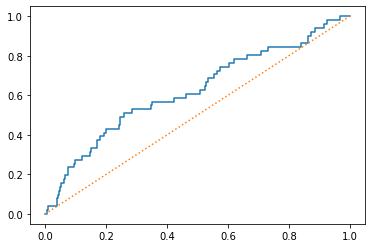

In [20]:
fpr,tpr,thresholds = roc_curve(data_buy_train['Target'].values,oof_pred.data[:,0])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],':')

In [21]:
import optuna

In [22]:
def f1_metric_trh(y_true, y_pred, threshold = 0.5, **kwargs):
    return f1_score(y_true, (y_pred > threshold).astype(int), **kwargs)

def objective(trial):
    threshold = trial.suggest_float("threshold", 0.01, 0.99)
    return f1_metric_trh(data_buy_train['Target'].values,oof_pred.data[:,0], threshold)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


In [23]:
study.best_params,f1_metric_trh(data_buy_train['Target'].values,oof_pred.data[:,0], study.best_params['threshold'])

({'threshold': 0.03727378612786981}, 0.11764705882352941)

# Тестирование модели